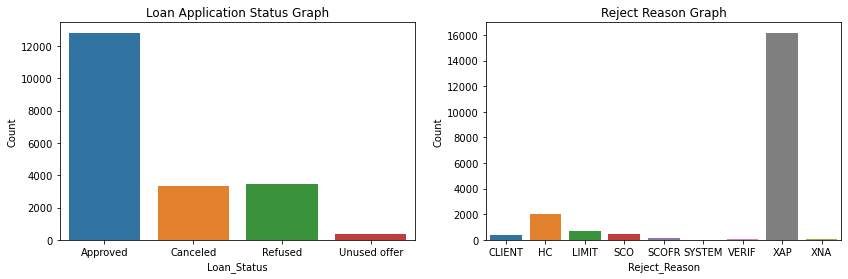

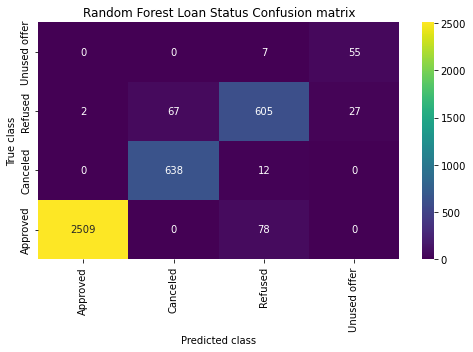

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


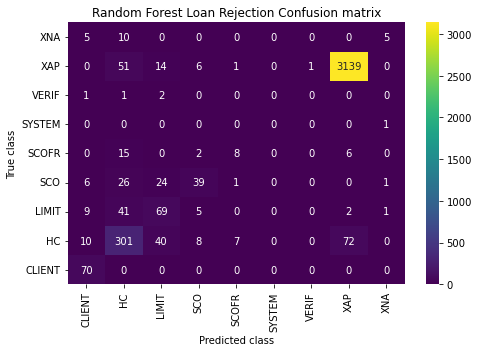

In [ ]:
from tkinter import *
import tkinter
from tkinter import filedialog
import numpy as np
from tkinter import simpledialog
from sklearn.model_selection import train_test_split
from tkinter import ttk
from tkinter.filedialog import askopenfilename
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier#importing ML classes
import shap


main = tkinter.Tk()
main.title("Future of Loan Approvals with Explainable AI") #designing main screen
main.geometry("1000x650")

global filename, loan_status, loan_reject_reason, status_names, reject_names, label_encoder, scaler, cols
global loan_X_train, loan_X_test, loan_y_train, loan_y_test
global reject_X_train, reject_X_test, reject_y_train, reject_y_test
global accuracy, precision, recall, fscore
global rf, reject_rf, dataset, X


def loadDataset():
    global filename, dataset, loan_status, loan_reject_reason, status_names, reject_names
    filename = filedialog.askopenfilename(initialdir="Dataset")
    text.delete('1.0', END)
    text.insert(END,filename+" loaded\n\n")
    dataset = pd.read_csv(filename, nrows=20000)
    text.insert(END,str(dataset.head()))
    loan_status = dataset['NAME_CONTRACT_STATUS']
    loan_reject_reason = dataset['CODE_REJECT_REASON']
    #visualizing loan status class labels
    status_names, status_count = np.unique(loan_status, return_counts = True)
    reject_names, reject_count = np.unique(loan_reject_reason, return_counts = True)
    loan_df = []
    for i in range(len(status_names)):
        loan_df.append([status_names[i], status_count[i]])
    loan_df = pd.DataFrame(loan_df, columns=['Loan_Status', 'Count'])
    reject_df = []
    for i in range(len(reject_names)):
        reject_df.append([reject_names[i], reject_count[i]])
    reject_df = pd.DataFrame(reject_df, columns=['Reject_Reason', 'Count'])    

    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    sns.barplot(x="Loan_Status", y='Count', data=loan_df, ax=axs[0])
    sns.barplot(x="Reject_Reason", y='Count', data=reject_df, ax=axs[1])
    axs[0].set_title("Loan Application Status Graph")
    axs[1].set_title("Reject Reason Graph")
    plt.show()

def processDataset():
    text.delete('1.0', END)
    global dataset, scaler, label_encoder, cols, loan_status, loan_reject_reason, X
    label_encoder = []
    #converting non-numeric data to numeric values
    dataset.fillna(0, inplace = True)
    label_encoder = []
    columns = dataset.columns
    types = dataset.dtypes.values
    cols = []
    for i in range(len(types)):
        name = types[i]
        if name == 'object': #finding column with object type
            le = LabelEncoder()
            dataset[columns[i]] = pd.Series(le.fit_transform(dataset[columns[i]].astype(str)))#encode all str columns to numeric
            label_encoder.append(le)
            cols.append(columns[i])
    dataset.fillna(0, inplace = True)
    loan_status = dataset['NAME_CONTRACT_STATUS']
    loan_reject_reason = dataset['CODE_REJECT_REASON']
    dataset.drop(['NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON'], axis = 1,inplace=True)
    X = dataset.values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)#normalize train features
    text.insert(END,"Normalized * Processed Features = "+str(X))

def splitDataset():
    text.delete('1.0', END)
    global X, loan_status, loan_reject_reason
    global loan_X_train, loan_X_test, loan_y_train, loan_y_test
    global reject_X_train, reject_X_test, reject_y_train, reject_y_test
    #split dataset into train and test
    loan_X_train, loan_X_test, loan_y_train, loan_y_test = train_test_split(X, loan_status, test_size = 0.2)
    reject_X_train, reject_X_test, reject_y_train, reject_y_test = train_test_split(X, loan_reject_reason, test_size = 0.2)
    text.insert(END,"Total records found in dataset = "+str(X.shape[0])+"\n")
    text.insert(END,"Total features found in dataset= "+str(X.shape[1])+"\n")
    text.insert(END,"80% dataset for training : "+str(loan_X_train.shape[0])+"\n")
    text.insert(END,"20% dataset for testing  : "+str(loan_X_test.shape[0])+"\n")

def calculateMetrics(algorithm, predict, y_test, label_names):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    text.insert(END,algorithm+" Accuracy  :  "+str(a)+"\n")
    text.insert(END,algorithm+" Precision : "+str(p)+"\n")
    text.insert(END,algorithm+" Recall    : "+str(r)+"\n")
    text.insert(END,algorithm+" FScore    : "+str(f)+"\n\n")    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(7, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = label_names, yticklabels = label_names, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(label_names)])
    plt.title(algorithm+" Confusion matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class')
    plt.tight_layout()
    plt.show()        

def aiApproval():
    text.delete('1.0', END)
    global loan_X_train, loan_X_test, loan_y_train, loan_y_test
    global reject_X_train, reject_X_test, reject_y_train, reject_y_test
    global accuracy, precision, recall, fscore, rf, status_names
    #define global variables to save accuracy and other metrics
    accuracy = []
    precision = []
    recall = []
    fscore = []
    rf = RandomForestClassifier()
    rf.fit(loan_X_train, loan_y_train)
    predict = rf.predict(loan_X_test)
    calculateMetrics("Random Forest Loan Status", predict, loan_y_test, status_names)

def aiReject():
    global reject_X_train, reject_X_test, reject_y_train, reject_y_test
    global accuracy, precision, recall, fscore, rf, reject_names, reject_rf
    reject_rf = RandomForestClassifier()
    reject_rf.fit(reject_X_train, reject_y_train)
    predict = reject_rf.predict(reject_X_test)
    calculateMetrics("Random Forest Loan Rejection", predict, reject_y_test, reject_names)

def explainAI():
    global rf
    features_names = ['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
                      'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT',
                      'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE', 'DAYS_DECISION',
                      'NAME_PAYMENT_TYPE', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
                      'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP',
                      'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
                      'NFLAG_INSURED_ON_APPROVAL']
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(loan_X_test[0:200])
    shap.summary_plot(shap_values, feature_names=features_names)
    plt.show()
    

def predict():
    text.delete('1.0', END)
    global rf, reject_rf, scaler, label_encoder, cols, status_names, reject_names
    filename = filedialog.askopenfilename(initialdir="Dataset")
    test_data = pd.read_csv(filename)
    test_data.fillna(0, inplace = True)
    for i in range(len(cols)):
        test_data[cols[i]] = pd.Series(label_encoder[i].transform(test_data[cols[i]].astype(str)))
        test_data.fillna(0, inplace = True)
    test_data.drop(['NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON'], axis = 1,inplace=True)
    test = test_data.values
    X = test_data.values
    X = scaler.transform(X)
    loan_predict = rf.predict(X)
    reject_predict = reject_rf.predict(X)
    for i in range(len(loan_predict)):
        text.insert(END,"Test Data = "+str(test[i])+"\n")
        text.insert(END,"Loan Approval Status = "+str(status_names[loan_predict[i]])+"\n")
        text.insert(END,"Loan Approval/Rejection Reason = "+str(reject_names[reject_predict[i]])+"\n\n")    
    

font = ('times', 16, 'bold')
title = Label(main, text='Future of Loan Approvals with Explainable AI', justify=LEFT)
title.config(bg='lavender blush', fg='DarkOrchid1')  
title.config(font=font)           
title.config(height=3, width=120)       
title.place(x=100,y=5)
title.pack()

font1 = ('times', 13, 'bold')
uploadButton = Button(main, text="Upload Loan Application Dataset", command=loadDataset)
uploadButton.place(x=10,y=100)
uploadButton.config(font=font1)

processButton = Button(main, text="Preprocess Dataset", command=processDataset)
processButton.place(x=330,y=100)
processButton.config(font=font1) 

splitButton = Button(main, text="Split Dataset Train & Test", command=splitDataset)
splitButton.place(x=620,y=100)
splitButton.config(font=font1) 

approvalButton = Button(main, text="Train AI on Loan Approval", command=aiApproval)
approvalButton.place(x=10,y=150)
approvalButton.config(font=font1)

rejectButton = Button(main, text="Train AI on Loan Rejections", command=aiReject)
rejectButton.place(x=330,y=150)
rejectButton.config(font=font1)

explainButton = Button(main, text="Explainable AI", command=explainAI)
explainButton.place(x=620,y=150)
explainButton.config(font=font1)

predictButton = Button(main, text="Predict Loan Status using Test Data", command=predict)
predictButton.place(x=820,y=150)
predictButton.config(font=font1)

font1 = ('times', 12, 'bold')
text=Text(main,height=22,width=140)
scroll=Scrollbar(text)
text.configure(yscrollcommand=scroll.set)
text.place(x=10,y=200)
text.config(font=font1)

main.config(bg='light coral')
main.mainloop()
